In [1]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import time
import os
import matplotlib.pyplot as plt
import PIL
import imageio
import re
from IPython import display
print(tf.__version__)

2.0.0


In [2]:
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_images, _), (self.test_images, _) = mnist.load_data()
        self.train_images = self.train_images.reshape(self.train_images.shape[0], 28, 28, 1).astype('float32')
        self.test_images = self.test_images.reshape(self.test_images.shape[0], 28, 28, 1).astype('float32')

        # 标准化图片到区间 [0., 1.] 内
        self.train_images /= 255.
        self.test_images /= 255.

        # 二值化
        self.train_images[self.train_images >= .5] = 1.
        self.train_images[self.train_images < .5] = 0.
        self.test_images[self.test_images >= .5] = 1.
        self.test_images[self.test_images < .5] = 0.
        
        self.train_dataset = tf.data.Dataset.from_tensor_slices(self.train_images).shuffle(TRAIN_BUF).batch(batch_size)
        self.test_dataset = tf.data.Dataset.from_tensor_slices(self.test_images).shuffle(TEST_BUF).batch(batch_size)

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape((7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=(2, 2), padding='same', activation=tf.nn.relu),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=(2, 2), padding='same', activation=tf.nn.relu),
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding='same'),
            ]
        )
        
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
        
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

TRAIN_BUF = 60000
TEST_BUF = 10000
num_epochs = 10
batch_size = 128
learning_rate = 0.001
latent_dim = 50
num_examples_to_generate = 16

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

random_vector_for_generation = tf.random.normal(shape=(num_examples_to_generate, latent_dim))

model = VAE(latent_dim)

def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    filenames=sorted((fn for fn in os.listdir('image/') if fn.startswith('image_at_epoch_')))
    result = re.findall('\d+', filenames[-1])
    epoch = int(result[0]) + 1
    plt.savefig('image/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


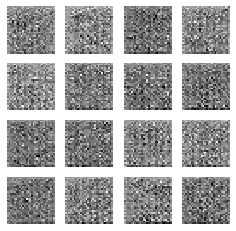

In [3]:
data_loader = MNISTLoader()

generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 10, Test set ELBO: -80.3396987915039, time elapse for current epoch 43.95248985290527


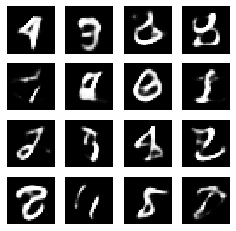

In [5]:
checkpoint_path = "training_VAE_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
if(latest != None):
    model.load_weights(latest)
    
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    for train_x in data_loader.train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in data_loader.test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
        
        generate_and_save_images(model, epoch, random_vector_for_generation)
        model.save_weights(checkpoint_path.format(epoch=epoch))

(-0.5, 287.5, 287.5, -0.5)

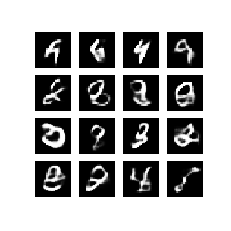

In [38]:
def display_image(epoch_no):
    return PIL.Image.open('image/image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(num_epochs))
plt.axis('off')#显示图片

In [47]:
anim_file = 'image/vae.gif'

images = []
filenames=sorted((fn for fn in os.listdir('image/') if fn.endswith('.png')))

for filename in filenames:
    images.append(imageio.imread('image/' + filename))
imageio.mimsave(anim_file, images,duration=1)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
#如果使用 Colab，可以使用以下代码下载动画
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

10
